In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import math
import os
from moviepy.editor import VideoFileClip
from IPython.display import HTML
from PIL import Image
import glob
import io
from sklearn import linear_model
import base64
from IPython.display import HTML
%matplotlib inline

In [2]:
def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """

    for line in lines:
        for x1,y1,x2,y2 in line:
            m = (y2 - y1) / (x2 - x1)
            if(m == 0):
                m = 1.e-6
            b = y1 - m*x1
            
            #x = np.array([x1,x2])  
            #y = np.array([y1,y2])  
            #clf = linear_model.LinearRegression(fit_intercept=False)
            #clf.fit(x, y)
            #print (clf.coef_)
            #print (np.dot(x, clf.coef_))
            
            ytop = 0
            xtop = (ytop - b) / m
            ybot = img.shape[0]
            xbot = (ybot - b) / m
            cv2.line(img, (int (xtop), ytop), (int (xbot), ybot), color, thickness)
     
    
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines, thickness=10)
    return line_img


def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def weighted_img(img, initial_img, α=0.9, β=0.7, λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

<function matplotlib.pyplot.show>

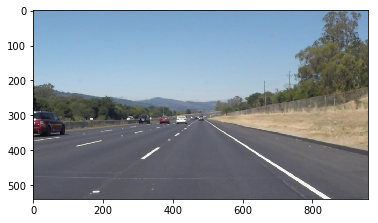

In [3]:
#reading in an image
img = mpimg.imread('test_images/solidWhiteRight.jpg')
plt.imshow(img)
plt.show

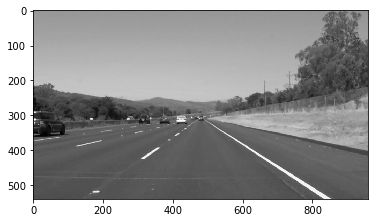

In [4]:
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
plt.imshow(gray, cmap='gray')
plt.show()

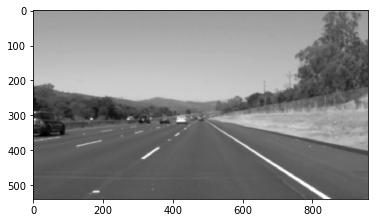

In [5]:
kernel_size = 9
blur = cv2.GaussianBlur(gray, (kernel_size, kernel_size), 0)
plt.imshow(blur, cmap='gray')
plt.show()

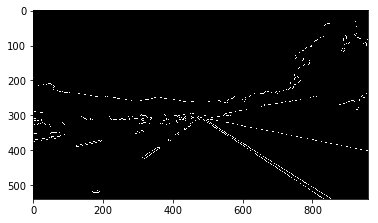

In [6]:
# the Canny function select edges based on the two values: low_treshold and high_threshold
# the two values are used to distinguish "real edges" from "not edges". 
# Everything is above the high_threshold is recognized as edge.
# Everything is below the low_threshold is recognized as not edge.
# Edges between the two threshold are defined egdes or not based on their connectivity.
 
canny = cv2.Canny(blur, 50, 120)
plt.imshow(canny, cmap='gray')
plt.show()

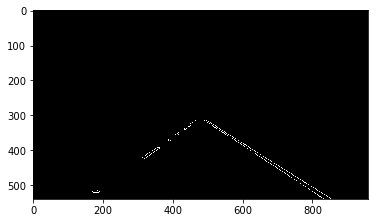

In [7]:
bot_left   = [80, 540]
bot_right  = [980, 540]
apex_right = [510, 315]
apex_left  = [450, 315]
v = [np.array([bot_left, bot_right, apex_right, apex_left], dtype=np.int32)]
    
mask = region_of_interest(canny, v)
plt.imshow(mask, cmap='gray')
plt.show()

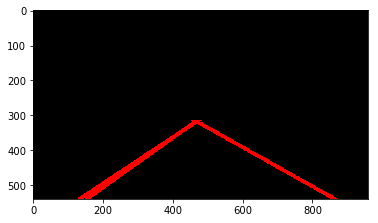

In [8]:
rho           = 60
theta         = np.pi/360
threshold     = 20
minLineLength = 130
maxLineGap    = 90
lines = hough_lines(mask, rho, theta, threshold, minLineLength, maxLineGap)
line_img = region_of_interest(lines, v)
plt.imshow(line_img, cmap='gray')
plt.show()

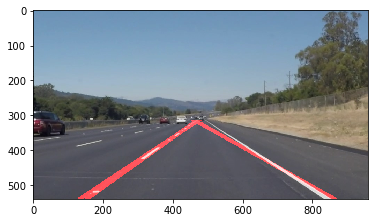

In [9]:
final = weighted_img(line_img, img)
plt.imshow(final)
plt.show()